**Human Similairty detection using DETR and VGGFace** 


In [1]:
#creating onnection to google drive
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
path = "/content/drive/MyDrive/try" #path to the google drive

In [3]:
!pip install git+https://github.com/rcmalli/keras-vggface.git
# Release Version
!pip install keras_vggface
!pip install keras_applications

  Cloning https://github.com/rcmalli/keras-vggface.git to /tmp/pip-req-build-5m3vxjgq
  Running command git clone -q https://github.com/rcmalli/keras-vggface.git /tmp/pip-req-build-5m3vxjgq
  Created wheel for keras-vggface: filename=keras_vggface-0.6-cp36-none-any.whl size=8311 sha256=fcb6e1326c52fea68785c1448b12bd2aec7cc661ea4f715f813e3cf1e934c72e
  Stored in directory: /tmp/pip-ephem-wheel-cache-2rlmn2yw/wheels/36/07/46/06c25ce8e9cd396dabe151ea1d8a2bc28dafcb11321c1f3a6d
Successfully built keras-vggface


In [4]:
#importing all the necessary packages


from collections import Counter
import warnings
import os
import numpy as np
import pandas as pd
import time
import imageio
import statistics
import collections
from matplotlib import image
from skimage import io
from skimage.transform import resize
import skimage
import glob
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from imblearn.under_sampling import RandomUnderSampler
from skimage import exposure
from scipy.ndimage import gaussian_filter
from skimage import data, exposure, img_as_float
from skimage import util
from sklearn.metrics import classification_report
import sklearn.metrics as metrics
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from skimage.io import imread_collection
from sklearn.model_selection import StratifiedShuffleSplit
from matplotlib import image
import skimage
import matplotlib.pyplot as plt
from skimage.util import crop
from sklearn.model_selection import train_test_split


import tensorflow.keras
from tensorflow.keras.applications import VGG16
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, Flatten, Dropout, MaxPooling2D, Input, Lambda
from tensorflow.keras.models import Model
from keras_vggface.vggface import VGGFace
from keras_vggface.utils import preprocess_input
from tensorflow.keras import backend as K
from tensorflow import keras
from tensorflow.keras import layers


import torch as th
import torchvision.transforms as T
import requests
from PIL import Image, ImageDraw, ImageFont

/usr/local/lib/python3.6/dist-packages/sklearn/externals/six.py:31: FutureWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.neighbors.base module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.neighbors. Anything that cannot be imported from sklearn.neighbors is now part of the private API.
  warnings.warn(message, FutureWarning)


Section I : Loading images and creating image pairs

In [5]:
#loading the data from the image folder
def load(folder_name):
    img = []
    for img_files in sorted(glob.glob(os.path.join(path, '*.jpg'))):
        img1 = io.imread(img_files)
        img1 = resize(img1,(150, 150,3))
        img.append(img1)
    return img

train_data = load(path) #all the images

In [6]:
#this function is used to make pairs 
def get_pairs(type_of_data):
    pairs = []
    for i in range(len(type_of_data)):
        for j in range((i+1), len(type_of_data)):
            im1 = type_of_data[i]
            im2 = type_of_data[j]
            pair = (im1,im2) #creating a pair of 2 images(one pair)
            pairs.append(pair)
    return pairs
    
pairs = get_pairs(train_data) #pairs in the training data

print("The shape of the array which consists of pairs is ", np.array(pairs).shape) #the 2 is because of the tuple is pair of 2 images

The shape of the array which consists of pairs is  (6903, 2, 150, 150, 3)


In [7]:
#the three functions are used for calculating the class labels based on the file name
def get_files(foldername):
    file = []
    for root, dirs, files in os.walk(foldername):
        for filename in files:
            file.append(filename)
        return file
    
train = get_files(path) #list of all the files

def get_classes(files):
    img_classes = []
    for i in range(len(files)):
        file_name = files[i]
        img_class = (" ".join(file_name[0:6]))
        img_classes.append(img_class)
    return img_classes

def get_labels(classes):
    img_labels = []
    for i in range(len(classes)): #loop for making pairs of images
        for j in range((i+1), len(classes)):
            img1 = classes[i]
            img2 = classes[j]
            if img1 == img2:
                img_labels.append(1) #if same class, then 1
            else:
                img_labels.append(0) # else, 0
    return img_labels

classes = get_classes(train) #consists of all the files names
labels_true = get_labels(classes)  #all the true labels of the pairs
labels_true = np.array(labels_true) #converting to numpy array


In [8]:
 classes.sort()

In [9]:
pairs = np.array(pairs) #converting pairs to a numpy array

In [10]:
pairs.shape

(6903, 2, 150, 150, 3)

In [11]:
Counter(labels_true) #to check if the count of class label 1 and class label 0

Counter({0: 5549, 1: 1354})

In [12]:
undersample = RandomUnderSampler(sampling_strategy='majority') #perform undersampling

pairs_under = pairs.reshape(6903,135000) #we have to reshape the data 2D to perform undersampling(from (6903, 2, 150, 150) to (6903,135000)


x_under, y_under = undersample.fit_resample(pairs_under, labels_true)

#after undersampling no of pairs is changed from 6903 from 2708

x_under = x_under.reshape(2708,2,150,150,3) #after performing undersampling, we will reshape it back to the origial shape i.e(2,150,150)



/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


In [13]:
#splitting the data into train, test and validation
x_1, x_test, y_1, y_test = train_test_split(x_under,y_under, test_size = 0.2, stratify = y_under) 
x_train, x_v, y_train, y_v = train_test_split(x_1,y_1, test_size = 0.12, stratify = y_1) 

Section II : Creating a Human Similairty model using VGGFace as a feature extractor 

In [14]:
#creating a VGGFace model for feature extraction
vggface = VGGFace(model='vgg16', include_top=False,weights='vggface', input_shape=(150,150,3))
for layer in vggface.layers:
  layer.trainable=False


In [15]:
#siamese network architecture

left_input = tensorflow.keras.Input(shape = (150,150,3)) #first image
right_input = tensorflow.keras.Input(shape = (150,150,3)) #second image


encoded_l = vggface(left_input) #using vgg16 model to extract the features from first image in the tuple
encoded_r = vggface(right_input) #using vgg16 model to extract the features from second image in the tuple


concat = (K.concatenate([encoded_l, encoded_r])) #concatenating the two features

#model
x= (tensorflow.keras.layers.Conv2D(64, kernel_size=7, activation='relu', padding="same")) (concat)

x= (tensorflow.keras.layers.Conv2D(64, kernel_size=7,activation='relu', padding="same")) (x)

x= tensorflow.keras.layers.Flatten() (x)


x = (tensorflow.keras.layers.Dense(4096, activation='relu')) (x)


prediction = tensorflow.keras.layers.Dense(1,activation='sigmoid') (x) #final layer

In [16]:
siamese = Model(inputs=[left_input,right_input],outputs=prediction)
siamese.compile(loss="binary_crossentropy",optimizer= 'adam' ,metrics=['accuracy'])

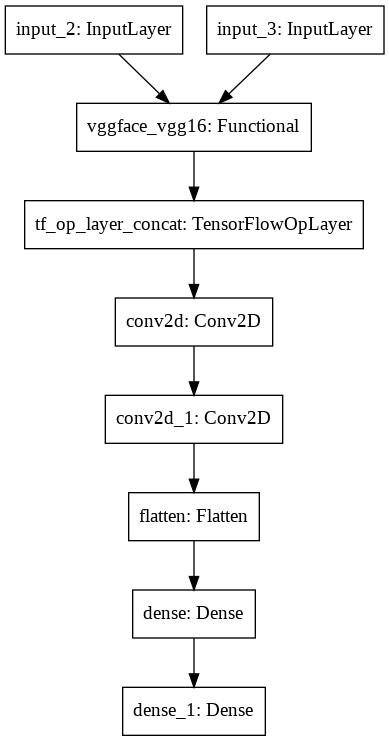

In [17]:
keras.utils.plot_model(siamese)

In [18]:
siamese.summary()

Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 150, 150, 3) 0                                            
__________________________________________________________________________________________________
input_3 (InputLayer)            [(None, 150, 150, 3) 0                                            
__________________________________________________________________________________________________
vggface_vgg16 (Functional)      (None, 4, 4, 512)    14714688    input_2[0][0]                    
                                                                 input_3[0][0]                    
__________________________________________________________________________________________________
tf_op_layer_concat (TensorFlowO [(None, 4, 4, 1024)] 0           vggface_vgg16[0][0]   

In [19]:
hist5 = siamese.fit([x_train[:,0],x_train[:,1]], y_train,
          batch_size=100,
          epochs=20,
          validation_data=([x_v[:,0],x_v[:,1]],y_v))

Epoch 1/20
20/20 [==============================] - 6s 325ms/step - loss: 0.7064 - accuracy: 0.4932 - val_loss: 0.6939 - val_accuracy: 0.4423
Epoch 2/20
20/20 [==============================] - 4s 214ms/step - loss: 0.6920 - accuracy: 0.5100 - val_loss: 0.6921 - val_accuracy: 0.5154
Epoch 3/20
20/20 [==============================] - 4s 214ms/step - loss: 0.6862 - accuracy: 0.5504 - val_loss: 0.7033 - val_accuracy: 0.5038
Epoch 4/20
20/20 [==============================] - 4s 214ms/step - loss: 0.6663 - accuracy: 0.5992 - val_loss: 0.6947 - val_accuracy: 0.5346
Epoch 5/20
20/20 [==============================] - 4s 215ms/step - loss: 0.6182 - accuracy: 0.6632 - val_loss: 0.7000 - val_accuracy: 0.6115
Epoch 6/20
20/20 [==============================] - 4s 214ms/step - loss: 0.5067 - accuracy: 0.7665 - val_loss: 0.6962 - val_accuracy: 0.6500
Epoch 7/20
20/20 [==============================] - 4s 215ms/step - loss: 0.3717 - accuracy: 0.8400 - val_loss: 0.5885 - val_accuracy: 0.7115
Epoch 

In [20]:
#evaluating on test data
score = siamese.evaluate([x_test[:,0],x_test[:,1]], y_test)

17/17 [==============================] - 2s 112ms/step - loss: 0.5670 - accuracy: 0.8875


The model is now trained and tested, and now ready to predict on new and unseen data. 

 Section III: Object Detection model using DETR

In [21]:
model_detr = th.hub.load('facebookresearch/detr', 'detr_resnet101', pretrained=True)
model_detr.eval()

Using cache found in /root/.cache/torch/hub/facebookresearch_detr_master


DETR(
  (transformer): Transformer(
    (encoder): TransformerEncoder(
      (layers): ModuleList(
        (0): TransformerEncoderLayer(
          (self_attn): MultiheadAttention(
            (out_proj): _LinearWithBias(in_features=256, out_features=256, bias=True)
          )
          (linear1): Linear(in_features=256, out_features=2048, bias=True)
          (dropout): Dropout(p=0.1, inplace=False)
          (linear2): Linear(in_features=2048, out_features=256, bias=True)
          (norm1): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
          (norm2): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
          (dropout1): Dropout(p=0.1, inplace=False)
          (dropout2): Dropout(p=0.1, inplace=False)
        )
        (1): TransformerEncoderLayer(
          (self_attn): MultiheadAttention(
            (out_proj): _LinearWithBias(in_features=256, out_features=256, bias=True)
          )
          (linear1): Linear(in_features=256, out_features=2048, bias=True)
       

In [22]:
transform = T.Compose([
    T.ToTensor(),
    T.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

CLASSES = [
    'N/A', 'person', 'bicycle', 'car', 'motorcycle', 'airplane', 'bus',
    'train', 'truck', 'boat', 'traffic light', 'fire hydrant', 'N/A',
    'stop sign', 'parking meter', 'bench', 'bird', 'cat', 'dog', 'horse',
    'sheep', 'cow', 'elephant', 'bear', 'zebra', 'giraffe', 'N/A', 'backpack',
    'umbrella', 'N/A', 'N/A', 'handbag', 'tie', 'suitcase', 'frisbee', 'skis',
    'snowboard', 'sports ball', 'kite', 'baseball bat', 'baseball glove',
    'skateboard', 'surfboard', 'tennis racket', 'bottle', 'N/A', 'wine glass',
    'cup', 'fork', 'knife', 'spoon', 'bowl', 'banana', 'apple', 'sandwich',
    'orange', 'broccoli', 'carrot', 'hot dog', 'pizza', 'donut', 'cake',
    'chair', 'couch', 'potted plant', 'bed', 'N/A', 'dining table', 'N/A',
    'N/A', 'toilet', 'N/A', 'tv', 'laptop', 'mouse', 'remote', 'keyboard',
    'cell phone', 'microwave', 'oven', 'toaster', 'sink', 'refrigerator', 'N/A',
    'book', 'clock', 'vase', 'scissors', 'teddy bear', 'hair drier',
    'toothbrush'
]

Section IV: Testing human similairty between two images using DETR and model constrctucted in Section II

In [23]:
#url of the first and second image

#url1 = "https://lh3.googleusercontent.com/proxy/v44EriBDRW98P7dDPcyU76utQzIhzDh7RuelA67k7qFrG41apAUzxF58MfPzD-9tLMH_6o51VhzYO6MebjUnmtPn5MnX7u-FyD109AA-tkHjjJalATwG6VYzm7gmyOVXQoveD_Z-"
url1= "https://www.etonline.com/sites/default/files/images/2020-01/gettyimages-146010584.jpg"
url2 = "https://i.pinimg.com/originals/a2/76/40/a2764030577b479616ee83e787bebd15.jpg"

In [24]:
#pre processing the image
def pre(url):
  img = Image.open(requests.get(url, stream=True).raw).resize((800,600))
  img_tens = transform(img).unsqueeze(0)
  with th.no_grad():
      output = model_detr(img_tens)
  return img,output

#drawing the bounding boxes for the label which the obj detection model predicts as "person"
def check(img,output):
  boxes = []
  imgs = []

  for logits, box in zip(output['pred_logits'][0], output['pred_boxes'][0]):
      cls = logits.argmax()
      if cls >= len(CLASSES):
        continue
      label = CLASSES[cls] 
      print('Labels are:')
      print(label)
    
      box = box.cpu() * th.Tensor([800, 600, 800, 600])
      x, y, w, h = box
      x0, x1 = x-w//2, x+w//2
      y0, y1 = y-h//2, y+h//2
      coords = (x0,y0,x1,y1)
      if (label=='person'):
        im2 = img.copy()
        im2.show()
        drw = ImageDraw.Draw(im2)
        drw.rectangle([x0, y0, x1, y1], outline='red', width=5)
        boxes.append(coords)
        imgs.append(im2)
  return boxes,imgs

In [25]:
#extracting the boundaries from the bousing boxes
def extract(boxes):
  
  final = []
  for i in range(len(boxes)):
    values = []
    a = boxes[i]
    for j in range(0,4):
      x = a[j]
      x = x.item()
      values.append(x)

    final.append(values)
    continue

  return final

In [26]:
#this function is used to crop the images according to the bounding box
def croping(values,images):
  person = []
  for i in range(len(values)):
    a,b,c,d = values[i]
    person1 = images[i].crop((a,b,c,d))
    person.append(person1)
  return person

In [27]:
#for first image
img1, output = pre(url1)
boxes,imgs = check(img1,output)
box1 = extract(boxes)
im1 = croping(box1,imgs)




Labels are:
person
Labels are:
person
Labels are:
tv


In [28]:
#for second image
img2,output1 = pre(url2)
boxes1,imgs1 = check(img2, output1)
box2 = extract(boxes1)
im2 = croping(box2,imgs1)

Labels are:
tie
Labels are:
person


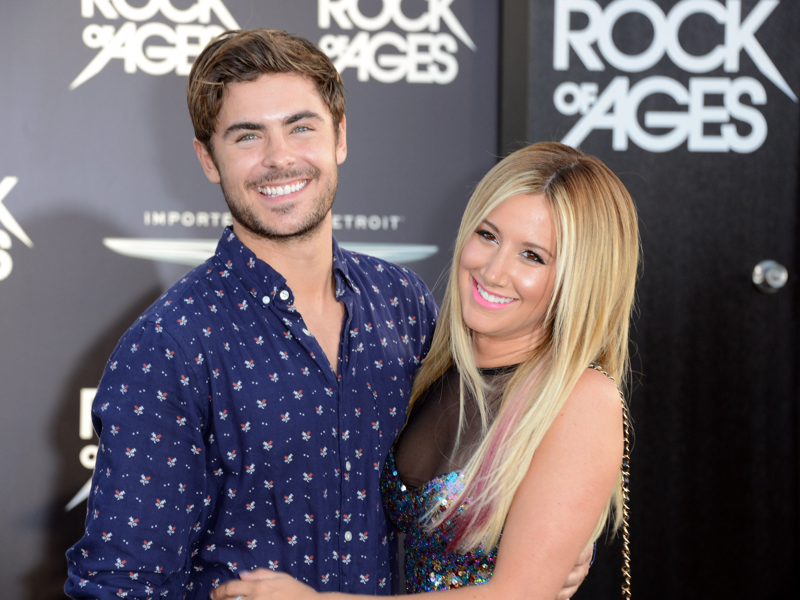

In [29]:
img1 #first image

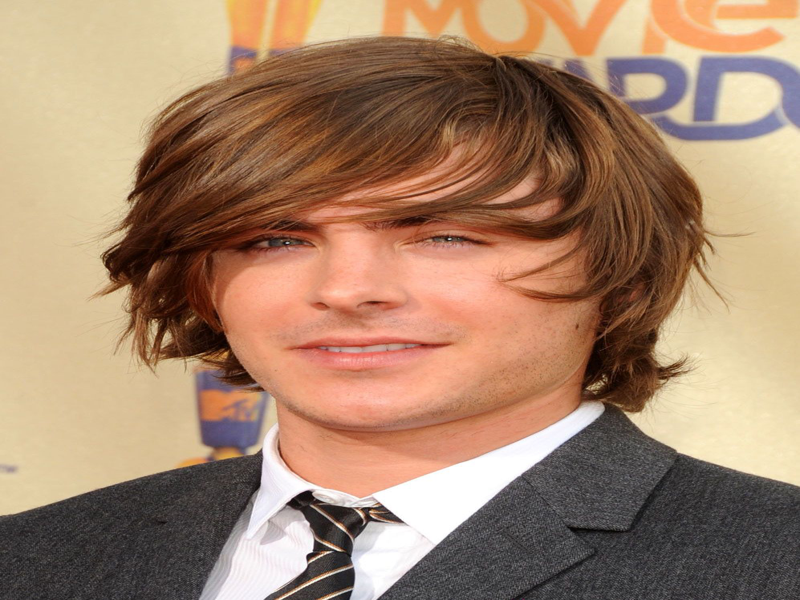

In [30]:
img2 #second image

In [31]:
from numpy import asarray 

def sets(images):
  first_img = []
  for i in range(len(images)):
    
    person = asarray(images[i])
    per = resize(person,(150,150))
    first_img.append(per)
  return first_img


img1 = sets(im1)
img2 = sets(im2)


In [32]:
#making pairs of images

trail = []
for i in range(len(img1)):
  for j in range(len(img2)):
    a = img1[i]
    b = img2[j]
    pairs = (a,b)
    trail.append(pairs)


In [33]:
trail = np.array(trail)

In [34]:
predictions = siamese.predict([trail[:,0], trail[:,1]])

In [35]:
predictions

array([[0.28312162],
       [0.80870795]], dtype=float32)

In [40]:
output1 = trail[1] #second pair has a high prediction value

In [41]:
#printing the output to show the similar persons
face1 = output1[0]
face2 = output1[1]

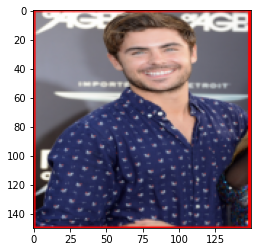

In [42]:

imgplot = plt.imshow(face1)

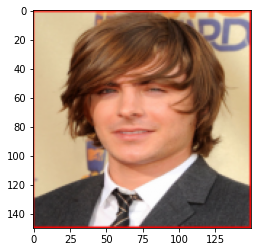

In [43]:
  imgplot = plt.imshow(face2)

References:
1. https://github.com/facebookresearch/detr
2. https://www.youtube.com/watch?v=LfUsGv-ESbc&t=630s
3. https://www.youtube.com/watch?v=T35ba_VXkMY
4. https://github.com/rcmalli/keras-vggface